In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch.nn.functional as F
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import math

Hyperparameters we need

In [2]:
device = 'cuda'

dataroot = '../data/face_data'

image_size = 128

batch_size = 96

We'll use fake face data scraped from thispersondoesnotexist.com to train our model. Here's what they look like

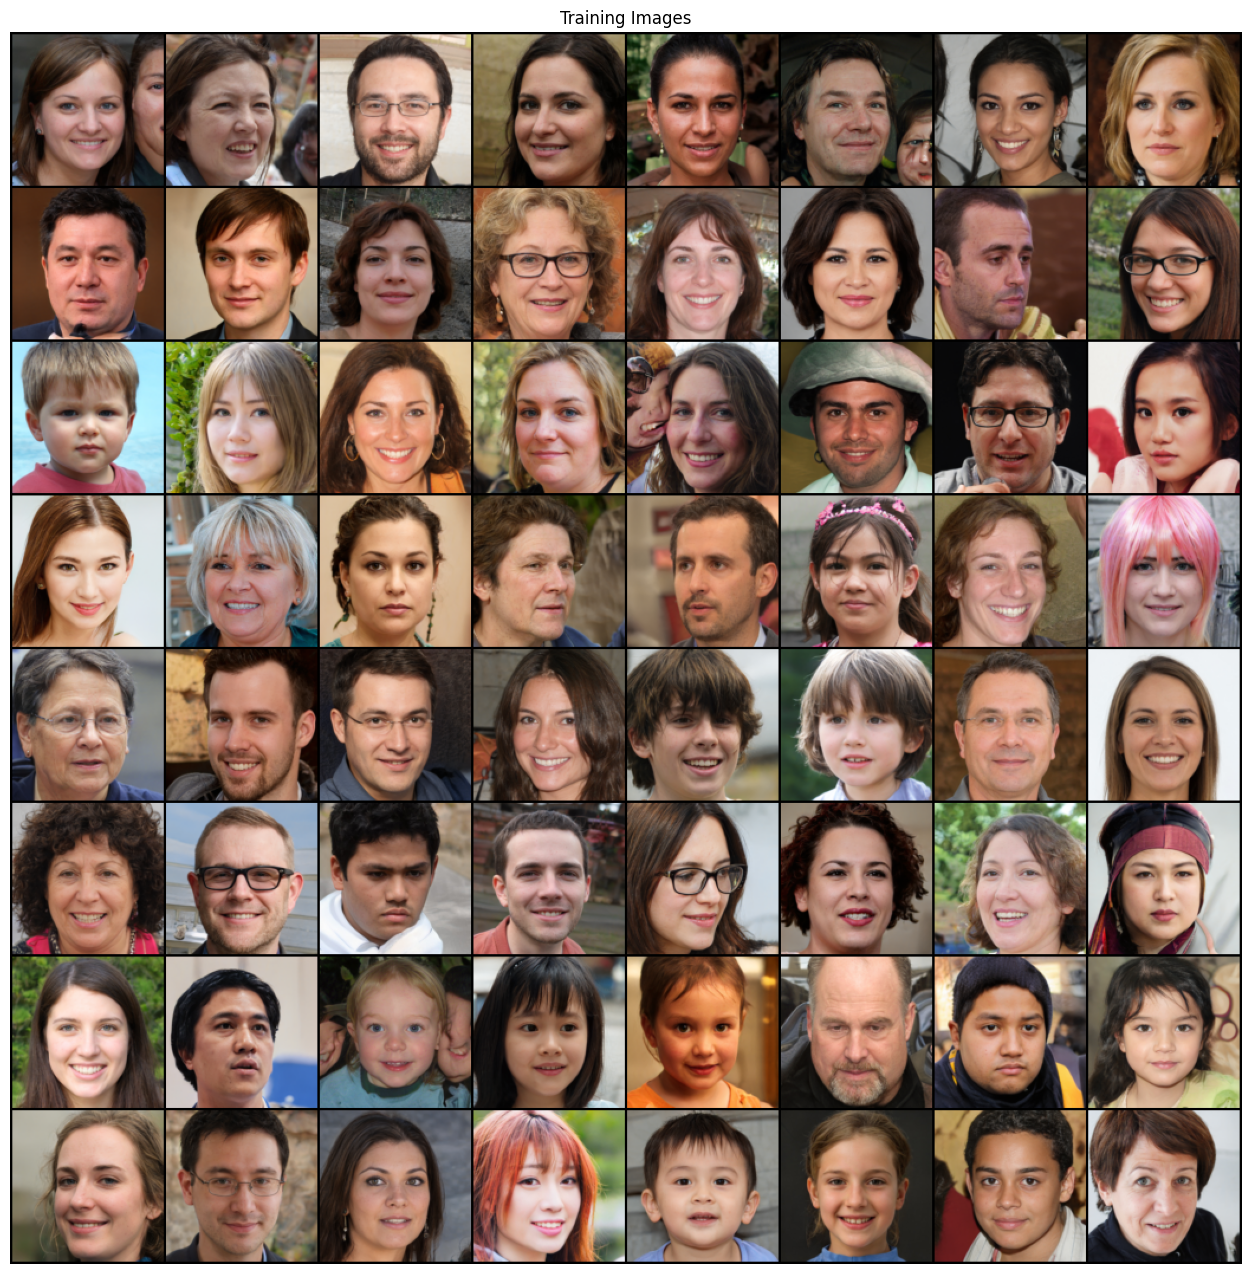

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2
)

# Plot some training images
batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

The gist of diffusion models is essentially forward and backward diffusion processes. We turn images into pure noise by forward diffusion, and use a backward diffusion process to turn random noise into images. Our neural network is used in the backward diffusion process. Instead of learning about images like in GANs, our model learn about noise distribution and how to reerse them.

We start with the forward diffusion process, which gradually adds random noise to an image, making it a complete image of noise by the end of certain amount of timestep. This is a Markov process, where the state of the current image depends only on the previous image. We denote the process as q.
$$
q(x_{i:T}|x_0)=\prod_{t=a}^{T} q(x_t|x_t-1) 
$$

Where x<sub>0</sub> = original image, T = total time step. And x<sub>1</sub> to x<sub>T</sub> are more and more noisy version of x<sub>0</sub>.
The way noise is sampled at time t is described by 
$$
\begin{align*}
q(x_t|x_{t-1}) &=N(x_t;\sqrt{1-{\beta}_t}x_{t-1}, {{\beta}_t}I) \\
&=\sqrt{1-{{\beta}_t}}x_{t-1}+\sqrt{{\beta}_t}\epsilon
\end{align*}
$$

$$ {\text{Where }} x_t=\text{output}, \sqrt{1-{{\beta}_t}}=\text{mean}, {{\beta}_t}I =\text{fixed variance}, {\epsilon\sim}N(0,1) \text{ meaning avg 0 and std 1} $$

Variance at time t is bascially how much noise we'd like to generate. Further, we define the following
$$
{\alpha}_t=1-{\beta}_t \\
{\overline{{\alpha}}_t} = \prod_{i=1}^{t} {\alpha}_t \\
$$
Combining this into our definition of q, we have
$$
\begin{align*}
q(x_t|x_{t-1})&=\sqrt{1-{{\beta}_t}}x_{t-1}+\sqrt{{\beta}_t}\epsilon \\
&=\sqrt{{\alpha}_t}x_{t-1}+\sqrt{1-{\alpha}_t}\epsilon \\
&=\sqrt{{\alpha}_t{\alpha}_{t-1}}x_{t-2}+\sqrt{1-{\alpha}_t{\alpha}_{t-1}}\epsilon \\
&=\sqrt{{\alpha}_t{\alpha}_{t-1}{\alpha}_{t-2}}x_{t-3}+\sqrt{1-{\alpha}_t{\alpha}_{t-1}{\alpha}_{t-2}}\epsilon \\
&=\sqrt{\overline{{\alpha}}_t}x_0+\sqrt{1-\overline{{\alpha}}_t}\epsilon \\
\end{align*}
$$

According to above, we can define the parameters and the forward diffusion process

In [4]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

T = 300

beta = linear_beta_schedule(timesteps=T).to(device)
alpha = 1 - beta
alpha_hat = torch.cumprod(alpha, axis=0)

alpha_hat_mean_term = torch.sqrt(alpha_hat)
alpha_hat_vari_term = torch.sqrt(1 - alpha_hat)

def forward_diffusion(x_0, timestep):
    x_0 = x_0.to(device)
    epsilon = torch.randn_like(x_0, device=device)
    return alpha_hat_mean_term[timestep] * x_0 + alpha_hat_vari_term[timestep] * epsilon, epsilon

To put the forward diffusion process in action and see the outcome

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0, 30, 60, 90, 120, 150, 180, 210, 240, 270]


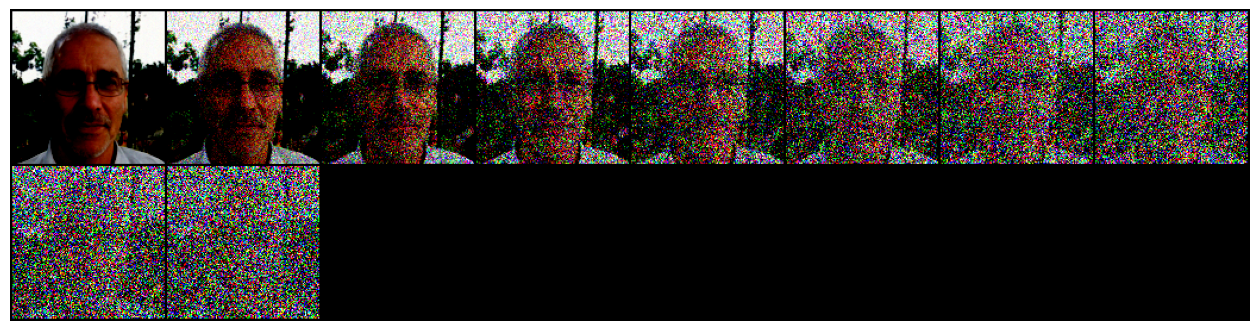

In [5]:
# Simulate forward diffusion
image = next(iter(dataloader))[0][0, :, :, :]

num_images = 10
timesteps = list(range(0, T, int(T / num_images)))
print(timesteps)

images = [forward_diffusion(image, timestep)[0] for timestep in timesteps]

plt.figure(figsize=(16,16))
plt.axis('off')
grid = vutils.make_grid(images)
plt.imshow((grid.permute(1, 2, 0)).cpu())

To accomadate with my personal hardware, I'm going to use a simplified U-net with sinusoidal position embedding for timestep. Keep in mind that the model architecture here is by **NO MEANS** the only option and is only intended for playing with generative diffusion. There are much improvements we could incorporate in the model, some of the ones I can think of include
<ul>
    <li>Residual Blocks</li>
    <li>Attention</li>
    <li>Batch / Group Normalization</li>
    <li>Other conditioning s.a. texts</li>
</ul>

In [6]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

And our loss function is defined as

In [7]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

The Backward Diffusion Process is recovering an image from random noise, and using the same symbols, the process is defined as
$$
X_{t-1} = \frac{1}{\sqrt{{\alpha}_t}}\Bigl(X_t - \frac{1-{\alpha}_t}{\sqrt{1-{\overline{{\alpha}}_t}}}M(X_t, t)\Bigl) + {\sigma}_t\epsilon \\
$$ 
Where M(x, t) is the forward function of our model.

In [8]:
@torch.no_grad()
def backward_diffusion(model, x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """

    y_hat = model(x, t)
    sigma = torch.sqrt(beta[t] * (1 - alpha_hat[t - 1]) / (1 - alpha_hat[t]))
    
    if t != 0:
        epsilon = torch.randn_like(x)
    else:
        epsilon = torch.zeros_like(x)

    x_prev = torch.sqrt(1 / alpha[t]) * (x - beta[t] * y_hat / torch.sqrt(1 - alpha_hat[t])) + sigma * epsilon
    return x_prev

@torch.no_grad()
def sample_plot_image(model):
    num_images = 10
    image = torch.randn((1, 3, image_size, image_size), device=device)
    images = []

    for i in range(0, T)[::-1]:
        t = torch.tensor([i], device=device)
        image = backward_diffusion(model, image, t)
        if i % int(T / num_images) == 0:
            image_copy = image.view(3, 128, 128)
            images.append(image_copy)

    plt.figure(figsize=(16,16))
    plt.axis('off')
    grid = vutils.make_grid(images)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.show()

Finanlly, we go ahead and train our model.

E0
Epoch 0 | step 000 Loss: 0.8124006390571594 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


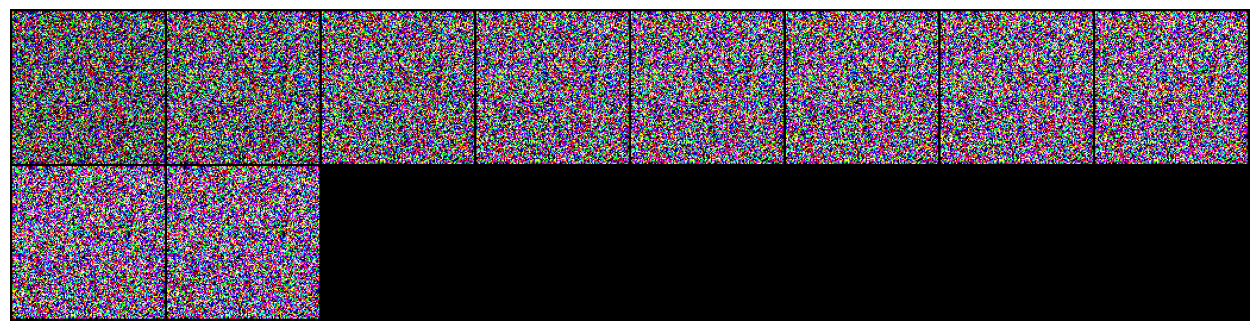

OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 12.00 GiB total capacity; 10.62 GiB already allocated; 0 bytes free; 11.03 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
from torch.optim import Adam

model = SimpleUnet().to(device)
# model.load_state_dict(torch.load('../3.5. Diffusion Result/model.pt'))
optimizer = Adam(model.parameters())
epochs = 50 # Try more!

for epoch in range(epochs):
  print(f'E{epoch}')
  for step, batch in enumerate(dataloader):
    optimizer.zero_grad()

    t = torch.randint(0, T, (1,), device=device)
    loss = get_loss(model, batch[0], t)
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 and step == 0:
      print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
      sample_plot_image(model)

In [ ]:
torch.save(model.state_dict(), 'model.pt')
# torch.save(model.state_dict(), '../models/face_diffusion.pt')

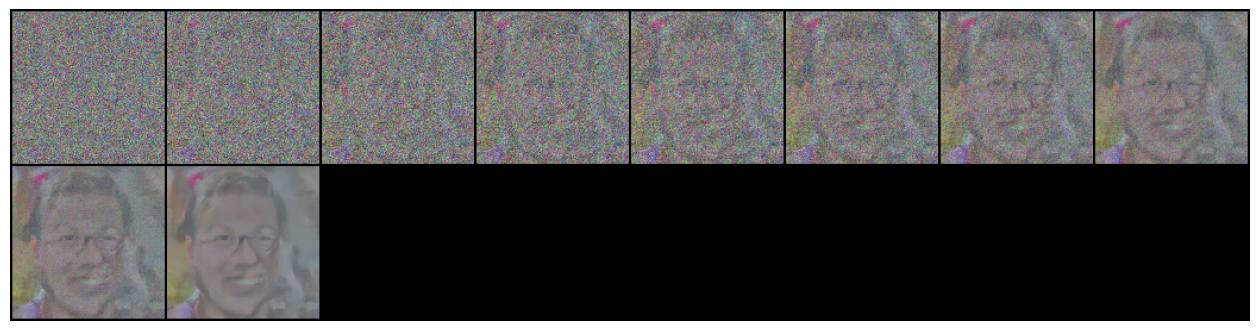

In [ ]:
sample_plot_image(model)